# Serial K-Means 1D 

## 1. Serial C Code 

In [1]:
%%writefile kmeans_1d_naive.c

/* kmeans_1d_naive.c
   K-means 1D (C99), implementação "naive":
   - Lê X (N linhas, 1 coluna) e C_init (K linhas, 1 coluna) de CSVs sem cabeçalho.
   - Itera assignment + update até max_iter ou variação relativa do SSE < eps.
   - Salva (opcional) assign (N linhas) e centróides finais (K linhas).
*/

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }

    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }

    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;

        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

// ---------- k-means 1D ----------
 /* assignment: para cada X[i], encontra c com menor (X[i]-C[c])^2 */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;
    for(int i=0;i<N;i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0;c<K;c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

/* update: média dos pontos de cada cluster (1D)
   se cluster vazio, copia X[0] (estratégia naive) */
static void update_step_1d(const double *X, double *C, const int *assign, int N, int K){
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    if(!sum || !cnt){ fprintf(stderr,"Sem memoria no update\n"); exit(1); }

    for(int i=0;i<N;i++){
        int a = assign[i];
        cnt[a] += 1;
        sum[a] += X[i];
    }
    for(int c=0;c<K;c++){
        if(cnt[c] > 0) C[c] = sum[c] / (double)cnt[c];
        else           C[c] = X[0]; /* simples: cluster vazio recebe o primeiro ponto */
    }
    free(sum); free(cnt);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out)
{
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);
        /* parada por variação relativa do SSE */
        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        printf("Obs: arquivos CSV com 1 coluna (1 valor por linha), sem cabeçalho.\n");
        return 1;
    }// k-means 1D
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int max_iter = (argc>3)? atoi(argv[3]) : 50;
    double eps   = (argc>4)? atof(argv[4]) : 1e-4;
    const char *outAssign   = (argc>5)? argv[5] : NULL;
    const char *outCentroid = (argc>6)? argv[6] : NULL;

    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); return 1; }

    clock_t t0 = clock();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse);
    clock_t t1 = clock();
    double ms = 1000.0 * (double)(t1 - t0) / (double)CLOCKS_PER_SEC;

    printf("K-means 1D (naive)\n");
    printf("N=%d K=%d max_iter=%d eps=%g\n", N, K, max_iter, eps);
    printf("Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);

    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);

    free(assign); free(X); free(C);
    return 0;
}


Writing kmeans_1d_naive.c


## 2. Compilar e executar o programa

In [2]:
# Compile (this works if 'gcc' is in your Windows System PATH)
!gcc -O2 -std=c99 kmeans_1d_naive.c -o kmeans_1d_naive.exe -lm

In [3]:
!.\kmeans_1d_naive.exe ..\dataset\dados.csv ..\dataset\centroides_iniciais.csv 50 1e-6 assign.csv centroids.csv

K-means 1D (naive)
N=1000000 K=16 max_iter=50 eps=1e-06
Iterações: 3 | SSE final: 3826358.595087 | Tempo: 43.0 ms


## 3. Visualizar resultados

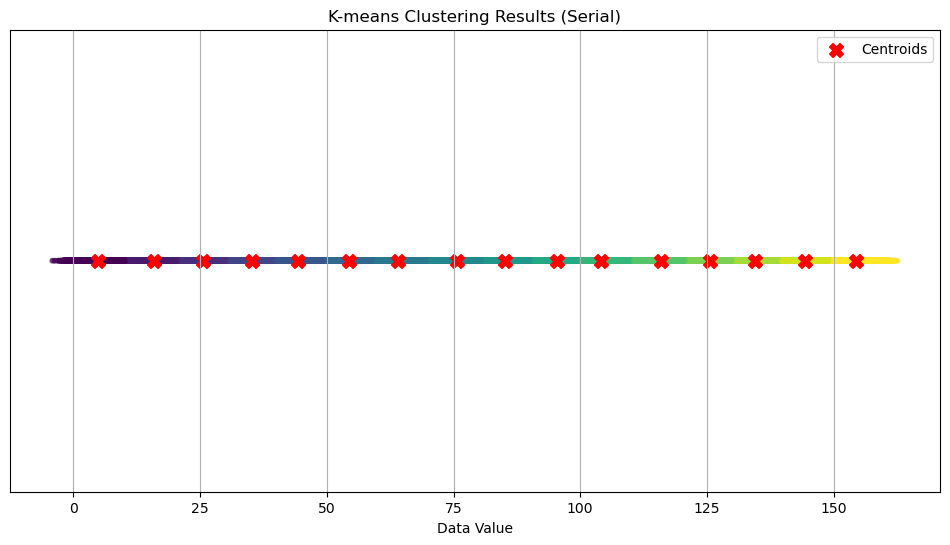

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the assignment and centroid files
try:
    assign_df = pd.read_csv('assign.csv', header=None, names=['cluster'])
    centroids_df = pd.read_csv('centroids.csv', header=None, names=['centroid'])
    # Read data from the shared dataset location
    data_df = pd.read_csv('../dataset/dados.csv', header=None, names=['value'])

    # Add the cluster assignments to the data DataFrame
    data_df['cluster'] = assign_df['cluster']

    # Plot the data points, colored by cluster
    plt.figure(figsize=(12, 6))
    plt.scatter(data_df['value'], [0] * len(data_df), c=data_df['cluster'], cmap='viridis', s=10, alpha=0.6)

    # Plot the centroids
    plt.scatter(centroids_df['centroid'], [0] * len(centroids_df), c='red', s=100, marker='X', label='Centroids')

    plt.title('K-means Clustering Results (Serial)')
    plt.xlabel('Data Value')
    plt.yticks([])
    plt.legend()
    plt.grid(True, axis='x')
    plt.show()
except FileNotFoundError:
    print("Output files not found. Make sure the C code ran successfully.")